In [1]:
from seriesNet_torch import *
import SeriesNetTrainTestManager
import seriesNet_torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import torch
import random
import glob
from action_500FN import action, load_dataset
import matplotlib.pyplot as plt
import fn_500_dataset
from fn_500_dataset import ActionDataset
from torch.utils.data import DataLoader
import importlib
import SeriesNetTrainTestManager as SNTTM

In [2]:
myModel = seriesNet(5, nb_causal_block=5,gate_nb_filter=16, nb_block_dropped=3)
print(myModel)

seriesNet(
  (module_block): ModuleList(
    (0): gated_block(
      (pad_input): ReflectionPad1d((1, 0))
      (conv): Conv1d(5, 16, kernel_size=(2,), stride=(1,), bias=False, padding_mode=reflect)
      (network_in): Conv1d(16, 5, kernel_size=(1,), stride=(1,), bias=False)
      (skipout): Conv1d(16, 5, kernel_size=(1,), stride=(1,), bias=False)
    )
    (1): gated_block(
      (pad_input): ReflectionPad1d((2, 0))
      (conv): Conv1d(5, 16, kernel_size=(2,), stride=(1,), dilation=(2,), bias=False, padding_mode=reflect)
      (network_in): Conv1d(16, 5, kernel_size=(1,), stride=(1,), bias=False)
      (skipout): Conv1d(16, 5, kernel_size=(1,), stride=(1,), bias=False)
    )
    (2): gated_block(
      (pad_input): ReflectionPad1d((4, 0))
      (conv): Conv1d(5, 16, kernel_size=(2,), stride=(1,), dilation=(4,), bias=False, padding_mode=reflect)
      (network_in): Conv1d(16, 5, kernel_size=(1,), stride=(1,), bias=False)
      (skipout): Conv1d(16, 5, kernel_size=(1,), stride=(1,), bi

In [7]:
importlib.reload(fn_500_dataset)
dataset = fn_500_dataset.ActionDataset(".\\individual_stocks_5yr/", normalise=True)
dataset_train, data_test = dataset[0:400].float(), dataset[400:].float() #torch.utils.data.random_split(dataset, [400,70])
print(len(dataset))
print(len(dataset_train))
print(len(data_test))
training_loader = DataLoader(dataset_train, batch_size=10, shuffle=False, drop_last=False)

lenght :  470
torch.Size([470, 5, 1259])
470
400
70


epoch 0


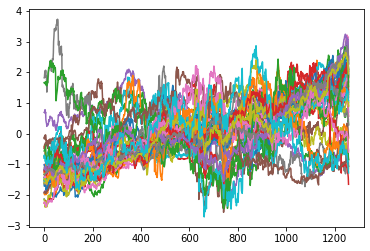

In [4]:
myModel = seriesNet(5, nb_causal_block=5,gate_nb_filter=16, nb_block_dropped=2)
#myModel = myModel.float()
dataset.float()
# CHOISIR UNE LOSS
criterion = nn.MSELoss()
optimizer = optim.SGD(myModel.parameters(), lr=0.0001, weight_decay=0.01)
#choice = torch.multinomial(torch.tensor(np.arange(data.size()[0])).float(), 1)
for i in range(1):
    print('epoch {}'.format(i))
    for i,batch in enumerate(training_loader):
        #print("batch s{}".format(i))
        inputModel, target = batch[:,:,:-1], batch[:,:,1:]
        plt.plot(inputModel[0,2])

In [6]:
dataset = fn_500_dataset.ActionDataset(".\\individual_stocks_5yr/", normalise=True)
dataset.float()
dataset_train, dataset_validation = torch.utils.data.random_split(dataset, (400, 70))
print(len(dataset))
print(len(dataset_train))
print(len(dataset_validation))
training_loader = DataLoader(dataset_train, batch_size=10, shuffle=True, drop_last=False)
valid_loader = DataLoader(dataset_validation, batch_size=10, shuffle=True, drop_last=False)

lenght :  470
torch.Size([470, 5, 1259])
470
400
70


In [131]:
# LES DATA DOIVENT ETRE DE LA FORME (N, C, TIMESERIES) OU N EST LE NOMBRE D'ELEMENTS DANS LA MINI BATCH
# C LE NOMBRE DE CANAUX, ET TIMESERIES LE NOMBRE DE POINTS DANS LA SERIE CHRONOLOGIQUE
# INITIALISER LE MODELE :
myModel = seriesNet(5, nb_causal_block=5,gate_nb_filter=16, nb_block_dropped=2)
myModel = myModel.float()
#dataset.float()
# CHOISIR UNE LOSS
criterion = nn.MSELoss()
optimizer = optim.SGD(myModel.parameters(), lr=0.001, weight_decay=0.01)
# TRACE DES METRICS
training_loss_epoch = []
valid_loss_epoch = []
#choice = torch.multinomial(torch.tensor(np.arange(data.size()[0])).float(), 1)
for i in range(30):
    print('epoch {}'.format(i+1))
    training_loss = []
    for j,batch in enumerate(training_loader):
        inputModel, target = batch[:,:,:-1], batch[:,:,1:]
        output = myModel(inputModel)
        optimizer.zero_grad()
        loss = criterion(output, target)
        loss.backward()
        #print(" loss : ", loss)
        optimizer.step()
        training_loss.append(loss.item())
        #print(training_loss)
    training_loss_epoch.append(np.mean(training_loss))
    myModel.eval()
    with torch.no_grad():
        valid_loss=[]
        for batch in valid_loader:
            inputModel, target = batch[:,:,:-1], batch[:,:,1:]
            output = myModel(inputModel)
            loss = criterion(output, target)
            valid_loss.append(loss.item())
        valid_loss_epoch.append(np.mean(valid_loss))
    print('Validation loss %.3f' % (valid_loss_epoch[-1]))
    myModel.train()

epoch 1
Validation loss 1.099
epoch 2
Validation loss 0.936
epoch 3
Validation loss 0.824
epoch 4
Validation loss 0.764
epoch 5
Validation loss 0.736
epoch 6
Validation loss 0.718
epoch 7
Validation loss 0.705
epoch 8
Validation loss 0.694
epoch 9
Validation loss 0.685
epoch 10
Validation loss 0.677
epoch 11
Validation loss 0.670
epoch 12
Validation loss 0.663
epoch 13
Validation loss 0.656
epoch 14
Validation loss 0.649
epoch 15
Validation loss 0.642
epoch 16
Validation loss 0.633
epoch 17
Validation loss 0.624
epoch 18
Validation loss 0.614
epoch 19
Validation loss 0.605
epoch 20
Validation loss 0.596
epoch 21
Validation loss 0.587
epoch 22
Validation loss 0.578
epoch 23
Validation loss 0.570
epoch 24
Validation loss 0.561
epoch 25
Validation loss 0.553
epoch 26
Validation loss 0.544
epoch 27
Validation loss 0.536
epoch 28
Validation loss 0.526
epoch 29
Validation loss 0.514
epoch 30
Validation loss 0.499


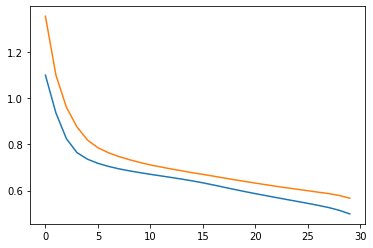

In [132]:
plt.plot(valid_loss_epoch)
plt.plot(training_loss_epoch)

1259
torch.Size([1, 5, 1209])


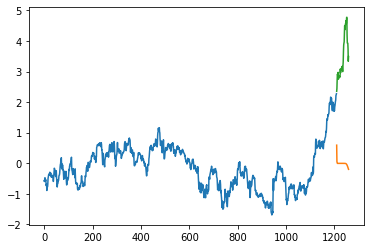

In [153]:
#On veut prédire les 15 prochains points d'une stock.
stockNb= 20
P = 50
C, L = dataset_validation[stockNb].size()
print(L)
X=dataset_validation[stockNb].view(1,5,1259)
cible = dataset_validation[stockNb][:,L-P:].detach().numpy()
print(dataset_validation[stockNb].view(1,5,1259)[:,:,:L-P].size())
X=dataset_validation[stockNb].view(1,5,1259)[:,:,:L-P]
if True :
    myModel.train()
    inputModel, target = X[:,:,:-1], X[:,:,1:]
    output = myModel(inputModel)
    optimizer.zero_grad()
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    myModel.eval()
prediction=torch.zeros(1, 5, 1)
with torch.no_grad():
    input_data = X
    for i in range(P):
        input_data=myModel(input_data)
        prediction = torch.cat((prediction, input_data[:,:,-1].view(1,C,1)), 2)

prediction.size()
#prediction = torch.cat((X,(prediction[:,:,1:])), 2)
prediction = prediction[:,:,1:].detach().numpy()[0]
abscisse = np.arange(0,1259)
data=X.detach().numpy()[0]
#print(abscisse.shape, data[1].shape)
plt.plot(abscisse[:-P],data[1])
plt.plot(abscisse[-P:], prediction[1])
plt.plot(abscisse[-P:],cible[1])


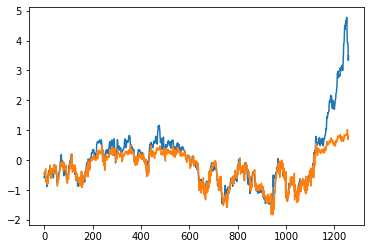

In [154]:
X=dataset_validation[20].view(1,5,1259)
Y=myModel(X)

plt.plot(X.detach().numpy()[0][1])
plt.plot(Y.detach().numpy()[0][1])


In [189]:
# LES DATA DOIVENT ETRE DE LA FORME (N, C, TIMESERIES) OU N EST LE NOMBRE D'ELEMENTS DANS LA MINI BATCH
# C LE NOMBRE DE CANAUX, ET TIMESERIES LE NOMBRE DE POINTS DANS LA SERIE CHRONOLOGIQUE
# INITIALISER LE MODELE :
myModel = seriesNet(5, nb_causal_block=5,gate_nb_filter=16, nb_block_dropped=2)
myModel = myModel.float()
N_2pred = 15
#dataset.float()
# CHOISIR UNE LOSS
criterion = nn.MSELoss()
optimizer = optim.SGD(myModel.parameters(), lr=0.001, weight_decay=0.01)
# TRACE DES METRICS
training_loss_epoch = []
valid_loss_epoch = []
#choice = torch.multinomial(torch.tensor(np.arange(data.size()[0])).float(), 1)
for i in range(30):
    print('epoch {}'.format(i+1))
    training_loss = []
    for j,batch in enumerate(training_loader):
        inputModel, target = batch[:,:,:-1], batch[:,:,1:]
        output = myModel(inputModel)
        optimizer.zero_grad()
        #On calcul la loss par rapport a la derniere prediction
        loss = criterion(output[:,:,-1].view(10,5,1), target[:,:,-1].view(10,5,1))
        loss.backward()
        optimizer.step()
        training_loss.append(loss.item())
    training_loss_epoch.append(np.mean(training_loss))
    myModel.eval()
    with torch.no_grad():
        valid_loss=[]
        for batch in valid_loader:
            inputModel, target = batch[:,:,:-1], batch[:,:,1:]
            output = myModel(inputModel)
            loss = criterion(output, target)
            valid_loss.append(loss.item())
        valid_loss_epoch.append(np.mean(valid_loss))
    print('Validation loss %.3f' % (valid_loss_epoch[-1]))
    myModel.train()

epoch 1
Validation loss 0.764
epoch 2
Validation loss 0.595
epoch 3
Validation loss 0.487
epoch 4
Validation loss 0.430
epoch 5
Validation loss 0.397
epoch 6
Validation loss 0.379
epoch 7
Validation loss 0.363
epoch 8
Validation loss 0.350
epoch 9
Validation loss 0.341
epoch 10
Validation loss 0.331
epoch 11
Validation loss 0.325
epoch 12
Validation loss 0.317
epoch 13
Validation loss 0.311
epoch 14
Validation loss 0.307
epoch 15
Validation loss 0.303
epoch 16
Validation loss 0.298
epoch 17
Validation loss 0.293
epoch 18
Validation loss 0.290
epoch 19
Validation loss 0.286
epoch 20
Validation loss 0.282
epoch 21
Validation loss 0.279
epoch 22
Validation loss 0.276
epoch 23
Validation loss 0.273
epoch 24
Validation loss 0.269
epoch 25
Validation loss 0.266
epoch 26
Validation loss 0.264
epoch 27
Validation loss 0.261
epoch 28
Validation loss 0.259
epoch 29
Validation loss 0.257
epoch 30
Validation loss 0.255


1259
torch.Size([1, 5, 1254])


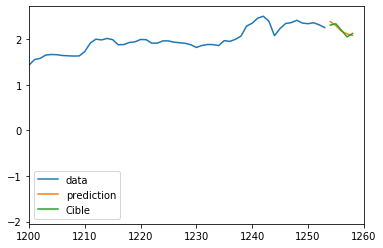

In [207]:
#On veut prédire les 15 prochains points d'une stock.
stockNb= random.randint(0,69)
P = 5
C, L = dataset_validation[stockNb].size()
print(L)
X=dataset_validation[stockNb].view(1,5,1259)
cible = dataset_validation[stockNb][:,L-P:].detach().numpy()
print(dataset_validation[stockNb].view(1,5,1259)[:,:,:L-P].size())
X=dataset_validation[stockNb].view(1,5,1259)[:,:,:L-P]
prediction=torch.zeros(1, 5, 1)
myModel.eval()
with torch.no_grad():
    input_data = X
    for i in range(P):
        input_data=myModel(input_data)
        prediction = torch.cat((prediction, input_data[:,:,-1].view(1,C,1)), 2)

prediction.size()
#prediction = torch.cat((X,(prediction[:,:,1:])), 2)
prediction = prediction[:,:,1:].detach().numpy()[0]
abscisse = np.arange(0,1259)
data=X.detach().numpy()[0]
#print(abscisse.shape, data[1].shape)
plt.plot(abscisse[:-P],data[1], label='data')
plt.plot(abscisse[-P:], prediction[1], label='prediction')
plt.plot(abscisse[-P:],cible[1],label ='Cible')
plt.xlim(1200,1260)
plt.legend()

In [95]:
#Strategie on predis les N_2Pred point et on s'entraine dessus 
# LES DATA DOIVENT ETRE DE LA FORME (N, C, TIMESERIES) OU N EST LE NOMBRE D'ELEMENTS DANS LA MINI BATCH
# C LE NOMBRE DE CANAUX, ET TIMESERIES LE NOMBRE DE POINTS DANS LA SERIE CHRONOLOGIQUE
# INITIALISER LE MODELE :
myModel = seriesNet_torch.seriesNet(5, nb_causal_block=5,gate_nb_filter=16, nb_block_dropped=2)
myModel = myModel.float()
N_2pred = 5
#dataset.float()
N, C, L = 10, 5, 1259
# CHOISIR UNE LOSS
criterion = nn.MSELoss()
optimizer = optim.SGD(myModel.parameters(), lr=0.001, weight_decay=0.01)
# TRACE DES METRICS
training_loss_epoch = []
valid_loss_epoch = []
#choice = torch.multinomial(torch.tensor(np.arange(data.size()[0])).float(), 1)
for i in range(20):
    print('epoch {}'.format(i+1))
    training_loss = []
    for j,batch in enumerate(training_loader):
        inputModel, target = batch[:,:,:L-N_2pred], batch[:,:,-N_2pred:]
        for k in range(N_2pred):
            output = myModel(inputModel)
            inputModel= torch.cat((inputModel,output[:,:,-1].view(10,5,1)),2)
        optimizer.zero_grad()
        #On calcul la loss par rapport a la derniere prediction
        loss = criterion(inputModel[:,:,-N_2pred:], target)
        loss.backward()
        optimizer.step()
        #inputModel= torch.cat((inputModel,output[:,:,-1].view(10,5,1)),2)
        training_loss.append(loss.item())
    training_loss_epoch.append(np.mean(training_loss))
    myModel.eval()
    with torch.no_grad():
        valid_loss=[]
        for batch in valid_loader:
            inputModel, target = batch[:,:,:L-N_2pred], batch[:,:,-N_2pred:]
            for k in range(N_2pred):
                output = myModel(inputModel)
                inputModel= torch.cat((inputModel,output[:,:,-1].view(10,5,1)),2)
            #output = myModel(inputModel)
            loss = criterion(inputModel[:,:,-N_2pred:], target)
            valid_loss.append(loss.item())
        valid_loss_epoch.append(np.mean(valid_loss))
    print('Validation loss %.3f' % (valid_loss_epoch[-1]))
    myModel.train()



epoch 1
Validation loss 1.027
epoch 2
Validation loss 0.616
epoch 3
Validation loss 0.528
epoch 4
Validation loss 0.502
epoch 5
Validation loss 0.488
epoch 6
Validation loss 0.484
epoch 7
Validation loss 0.477
epoch 8
Validation loss 0.472
epoch 9
Validation loss 0.470
epoch 10
Validation loss 0.464
epoch 11
Validation loss 0.461
epoch 12
Validation loss 0.459
epoch 13
Validation loss 0.456
epoch 14
Validation loss 0.452
epoch 15
Validation loss 0.450
epoch 16
Validation loss 0.447
epoch 17
Validation loss 0.444
epoch 18
Validation loss 0.441
epoch 19
Validation loss 0.442
epoch 20
Validation loss 0.436


1259
torch.Size([1, 5, 1254])


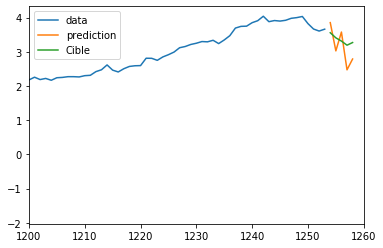

In [103]:
#On veut prédire les P prochains points d'une stock.
stockNb= random.randint(0,69)
P = 5
C, L = dataset_validation[stockNb].size()
print(L)
X=dataset_validation[stockNb].view(1,5,1259)
cible = dataset_validation[stockNb][:,L-P:].detach().numpy()
print(dataset_validation[stockNb].view(1,5,1259)[:,:,:L-P].size())
X=dataset_validation[stockNb].view(1,5,1259)[:,:,:L-P]
prediction=torch.zeros(1, 5, 1)
with torch.no_grad():
    input_data = X
    for i in range(P):
        input_data=myModel(input_data)
        prediction = torch.cat((prediction, input_data[:,:,-1].view(1,C,1)), 2)

prediction.size()
#prediction = torch.cat((X,(prediction[:,:,1:])), 2)
prediction = prediction[:,:,1:].detach().numpy()[0]
abscisse = np.arange(0,1259)
data=X.detach().numpy()[0]
#print(abscisse.shape, data[1].shape)
plt.plot(abscisse[:-P],data[1], label='data')
plt.plot(abscisse[-P:], prediction[1], label='prediction')
plt.plot(abscisse[-P:],cible[1],label ='Cible')
plt.xlim(1200,1260)
plt.legend()


In [226]:
2**4


16

In [243]:
conv0 = nn.Conv1d(in_channels=5, out_channels=5,
                kernel_size=2, stride=1, padding=0,dilation=1, bias=False)
conv1 = nn.Conv1d(in_channels=5, out_channels=5,
                kernel_size=2, stride=1, padding=0,dilation=2, bias=False)
conv2 = nn.Conv1d(in_channels=5, out_channels=5,
                kernel_size=2, stride=1, padding=0,dilation=4, bias=False)
conv3 = nn.Conv1d(in_channels=5, out_channels=5,
                kernel_size=2, stride=1, padding=0,dilation=8, bias=False)
conv4 = nn.Conv1d(in_channels=5, out_channels=5,
                kernel_size=2, stride=1, padding=0,dilation=16, bias=False)
X = torch.randn(10,5,1+2+4+8+16+1)
conv4(conv3(conv2(conv1(conv0(X))))).size()

torch.Size([10, 5, 1])

1259
torch.Size([5, 1254])
1222


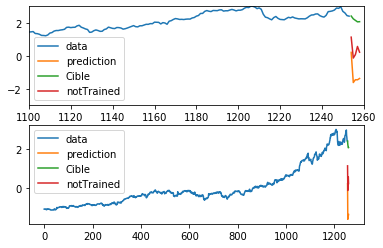

In [44]:
stockNb= random.randint(0,399)
P = 5
C, L = dataset_train[stockNb].size()
print(L)
start=1+2+4+8+16+1
myModel = seriesNet(5, nb_causal_block=5,gate_nb_filter=16, nb_block_dropped=2)
myModel = myModel.float()
print(dataset_train[stockNb][:,:L-P].size())
X=dataset_train[stockNb][:,:L-P].view(1,5,L-P)
pred_not_trained=torch.zeros(1, 5, 1)
with torch.no_grad():
    input_data = X
    for i in range(P):
        input_data=myModel(input_data)
        pred_not_trained = torch.cat((pred_not_trained, input_data[:,:,-1].view(1,C,1)), 2)

criterion = nn.MSELoss()
optimizer = optim.SGD(myModel.parameters(), lr=0.001, weight_decay=0.01)
print(L-P-start)
for i in range(L-P-start):
    pred=torch.zeros(1, 5, 1)
    input_data = X[:,:,i:start+i]
    for i in range(P):
        input_data=myModel(input_data)
        pred = torch.cat((pred, input_data[:,:,-1].view(1,C,1)), 2)
    #output = myModel(X[:,:,i:start+i])
    cible = X[:,:,start+i:start+i+P]
    optimizer.zero_grad()
    #On calcul la loss par rapport a la derniere prediction
    loss = criterion(pred[:,:,1:], cible)
    loss.backward()
    #print(loss.item())
    optimizer.step()
        
    
#cible = dataset_validation[stockNb][:,L-P:].detach().numpy()
#print(dataset_validation[stockNb].view(1,5,1259)[:,:,:L-P].size())
#X=dataset_validation[stockNb].view(1,5,1259)[:,:,:L-P]

cible=dataset_train[stockNb][:,L-P:].detach().numpy()
prediction=torch.zeros(1, 5, 1)
with torch.no_grad():
    input_data = X
    for i in range(P):
        input_data=myModel(input_data)
        prediction = torch.cat((prediction, input_data[:,:,-1].view(1,C,1)), 2)


prediction.size()
#prediction = torch.cat((X,(prediction[:,:,1:])), 2)
prediction = prediction[:,:,1:].detach().numpy()[0]
pred_not_trained =pred_not_trained[:,:,1:].detach().numpy()[0]
abscisse = np.arange(0,1259)
data=X.detach().numpy()[0]
#print(abscisse.shape, data[1].shape)
plt.subplot(211)
plt.plot(abscisse[:-P],data[1], label='data')
plt.plot(abscisse[-P:], prediction[1], label='prediction')
plt.plot(abscisse[-P:],cible[1],label ='Cible')
plt.plot(abscisse[-P:],pred_not_trained[1],label ='notTrained')
plt.xlim(1100,1260)
plt.ylim(-3,3)
plt.legend()
plt.subplot(212)
plt.plot(abscisse[:-P],data[1], label='data')
plt.plot(abscisse[-P:], prediction[1], label='prediction')
plt.plot(abscisse[-P:],cible[1],label ='Cible')
plt.plot(abscisse[-P:],pred_not_trained[1],label ='notTrained')

#plt.xlim(1200,1260)
plt.legend()


In [54]:
# Sliding window sur tout le dataset
#stockNb= random.randint(0,399)
N_2pred = 5
C, L = dataset_train[stockNb].size()
print(L)
start=1+2+4+8+16+1
myModel = seriesNet(5, nb_causal_block=5,gate_nb_filter=16, nb_block_dropped=2)
myModel = myModel.float()
#print(dataset_train[stockNb][:,:L-P].size())
#X=dataset_train[stockNb][:,:L-P].view(1,5,L-P)
criterion = nn.MSELoss()
optimizer = optim.SGD(myModel.parameters(), lr=0.001, weight_decay=0.01)


training_loss_epoch = []
valid_loss_epoch = []
#choice = torch.multinomial(torch.tensor(np.arange(data.size()[0])).float(), 1)
for i in range(5):
    print('epoch {}'.format(i+1))
    training_loss = []
    for j,batch in enumerate(training_loader):
        print('batch {}/{}'.format(j,len(training_loader)))
        inputModel, target = batch[:,:,:L-N_2pred], batch[:,:,-N_2pred:]
        for k in range(L-P-start):
            pred=torch.zeros(10, 5, 1)
            input_data = inputModel[:,:,i:start+i]
            for r in range(P):
                input_data=myModel(input_data)
                #print(pred.size())
                #print(input_data[:,:,-1].view(10,C,1).size())
                pred = torch.cat((pred, input_data[:,:,-1].view(10,C,1)), 2)
            #output = myModel(X[:,:,i:start+i])
            #print(pred.size())
            cible = inputModel[:,:,start+i:start+i+P]
            #print(cible.size())
            optimizer.zero_grad()
            #On calcul la loss par rapport a la derniere prediction
            loss = criterion(pred[:,:,1:], cible)
            loss.backward()
            #print(loss.item())
            optimizer.step()
            #inputModel= torch.cat((inputModel,output[:,:,-1].view(10,5,1)),2)
            training_loss.append(loss.item())
    training_loss_epoch.append(np.mean(training_loss))
    myModel.eval()
    with torch.no_grad():
        valid_loss=[]
        for batch in valid_loader:
            inputModel, target = batch[:,:,:L-N_2pred], batch[:,:,-N_2pred:]
            for k in range(N_2pred):
                output = myModel(inputModel)
                inputModel= torch.cat((inputModel,output[:,:,-1].view(10,5,1)),2)
            #output = myModel(inputModel)
            loss = criterion(inputModel[:,:,-N_2pred:], target)
            valid_loss.append(loss.item())
        valid_loss_epoch.append(np.mean(valid_loss))
    print('Validation loss %.3f' % (valid_loss_epoch[-1]))
    myModel.train()



  
stockNb= random.randint(0,399)
X=dataset_train[stockNb][:,:L-P]
cible=dataset_train[stockNb][:,L-P:].detach().numpy()
prediction=torch.zeros(1, 5, 1)
with torch.no_grad():
    input_data = X
    for i in range(P):
        input_data=myModel(input_data)
        prediction = torch.cat((prediction, input_data[:,:,-1].view(1,C,1)), 2)


prediction.size()
#prediction = torch.cat((X,(prediction[:,:,1:])), 2)
prediction = prediction[:,:,1:].detach().numpy()[0]
pred_not_trained =pred_not_trained[:,:,1:].detach().numpy()[0]
abscisse = np.arange(0,1259)
data=X.detach().numpy()[0]
#print(abscisse.shape, data[1].shape)
plt.subplot(211)
plt.plot(abscisse[:-P],data[1], label='data')
plt.plot(abscisse[-P:], prediction[1], label='prediction')
plt.plot(abscisse[-P:],cible[1],label ='Cible')
plt.xlim(1100,1260)
plt.ylim(-3,3)
plt.legend()
plt.subplot(212)
plt.plot(abscisse[:-P],data[1], label='data')
plt.plot(abscisse[-P:], prediction[1], label='prediction')
plt.plot(abscisse[-P:],cible[1],label ='Cible')

#plt.xlim(1200,1260)
plt.legend()


1259
epoch 1
batch 0/40
batch 1/40
batch 2/40
batch 3/40
batch 4/40
batch 5/40
batch 6/40
batch 7/40
batch 8/40
batch 9/40
batch 10/40
batch 11/40
batch 12/40
batch 13/40
batch 14/40
batch 15/40
batch 16/40
batch 17/40
batch 18/40
batch 19/40
batch 20/40
batch 21/40
batch 22/40
batch 23/40
batch 24/40
batch 25/40
batch 26/40
batch 27/40
batch 28/40
batch 29/40
batch 30/40
batch 31/40
batch 32/40
batch 33/40
batch 34/40
batch 35/40
batch 36/40
batch 37/40
batch 38/40
batch 39/40


NameError: name 'valid_loader' is not defined

<class 'int'>
<class 'int'> <class 'int'>
32


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 of 10


 10%|█         | 1/10 [00:06<01:00,  6.71s/it]

Epoch: 2 of 10


 20%|██        | 2/10 [00:12<00:52,  6.54s/it]

Epoch: 3 of 10


 30%|███       | 3/10 [00:20<00:48,  6.98s/it]

Epoch: 4 of 10


 40%|████      | 4/10 [00:26<00:39,  6.59s/it]

Epoch: 5 of 10


 50%|█████     | 5/10 [00:32<00:32,  6.52s/it]

Epoch: 6 of 10


 60%|██████    | 6/10 [00:39<00:26,  6.67s/it]

Epoch: 7 of 10


 70%|███████   | 7/10 [00:46<00:19,  6.54s/it]

Epoch: 8 of 10


 80%|████████  | 8/10 [00:53<00:13,  6.91s/it]

Epoch: 9 of 10


 90%|█████████ | 9/10 [01:01<00:07,  7.00s/it]

Epoch: 10 of 10


100%|██████████| 10/10 [01:07<00:00,  6.74s/it]


10


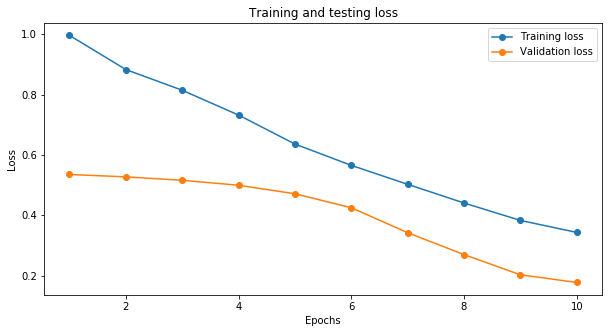

(5, 10)


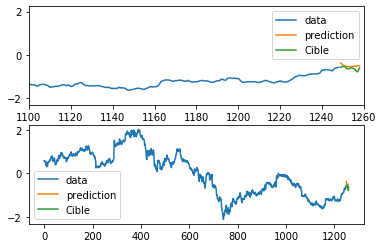

In [46]:
importlib.reload(SeriesNetTrainTestManager)
importlib.reload(seriesNet_torch)
myModel = seriesNet_torch.seriesNet(5, nb_causal_block=5,gate_nb_filter=16, nb_block_dropped=2)
myModel = myModel.float()
criterion = nn.MSELoss()
optimizer = optim.SGD(myModel.parameters(), lr=0.0001, weight_decay=0.01)
#dataset_train.float()
manager = SeriesNetTrainTestManager.TrainTestManager( myModel,
                                 dataset_train,
                                 dataset_validation,
                                 criterion,
                                 optimizer,
                                 batch_size=10)

index = random.randint(0,399)
manager.train_strategieB( epochs=10, data_index=index, pts_2pred = 10)
manager.plot_metrics()
manager.plot_prediction(index, 1, pts_2pred = 10)

(5, 20)


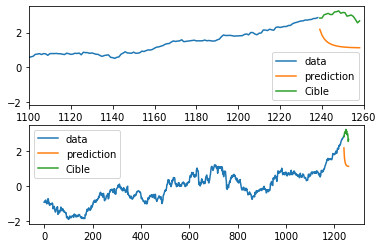

In [44]:
index = random.randint(0,399)
manager.plot_prediction(index, 1, pts_2pred = 20)

In [29]:
(2*np.ones(5)) ** np.arange(5)

array([ 1.,  2.,  4.,  8., 16.])

In [48]:
(18+27)/3

15.0

Epoch: 1 of 2
Epoch: 2 of 2


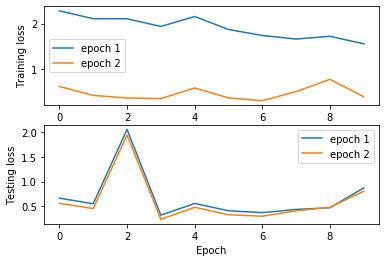

In [148]:
importlib.reload(SeriesNetTrainTestManager)
importlib.reload(seriesNet_torch)
myModels = [seriesNet_torch.seriesNet(5, nb_causal_block=5,gate_nb_filter=16, nb_block_dropped=2),
            seriesNet_torch.seriesNet(5, nb_causal_block=5,gate_nb_filter=16, nb_block_dropped=2)]
for model in myModels:
    model.float()

manager = SeriesNetTrainTestManager.TrainTestManager( 
                    myModels,
                    dataset_train,
                    dataset_validation,
                    lr=0.001,
                    batch_size=10)

#index = random.randint(0,399)
manager.pretrain(num_epochs=2, pts_2pred = 10)

#manager.plot_metrics()
#manager.plot_prediction(index, 1, pts_2pred = 10)

<class 'int'>
<class 'int'> <class 'int'>
32



  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1 of 2



 50%|█████     | 1/2 [00:16<00:16, 16.85s/it]

Epoch: 2 of 2



100%|██████████| 2/2 [00:35<00:00, 17.91s/it]


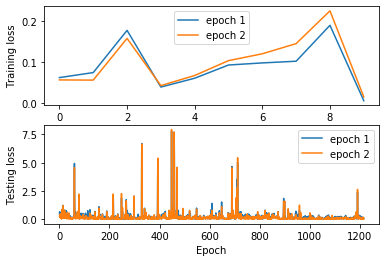

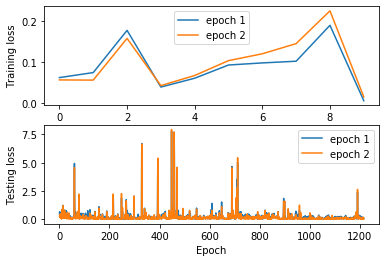

In [149]:
index = random.randint(0,399)
manager.train(2,index, pts_2pred=10)
manager.plot_Train_metrics()
#manager.plot_metrics()
#manager.plot_prediction(index, 1, pts_2pred = 10)

In [90]:
for param1, param2 in zip(manager.model.parameters(),manager.pre_trained_model.parameters()):
    print(param1.data == param2.data)

tensor([[[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [F

         [False]]])
tensor([[[False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         [False],
         [False],
         [False],
  

         [False, False]]])
tensor([[[False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         [False],
         [False],
         [Fal

         [False]]])


In [84]:
print(manager.model.parameters())
print(manager.pre_trained_model.parameters())
myModels = [seriesNet_torch.seriesNet(5, nb_causal_block=5,gate_nb_filter=16, nb_block_dropped=2),
            seriesNet_torch.seriesNet(5, nb_causal_block=5,gate_nb_filter=16, nb_block_dropped=2)]
print(myModels[0].parameters())
print(myModels[1].parameters())

for param1, param2 in zip(manager.model.parameters(),manager.pre_trained_model.parameters()):
    print(param1.data == param2.data)


<generator object Module.parameters at 0x0000016A13AD04C8>
<generator object Module.parameters at 0x0000016A13AD04C8>
<generator object Module.parameters at 0x0000016A13AD04C8>
<generator object Module.parameters at 0x0000016A13AD04C8>
tensor([[[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, 

         [True]]])
tensor([[[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],

         [True]]])
tensor([[[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],

<class 'int'>
<class 'int'> <class 'int'>
32


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 of 10


 10%|█         | 1/10 [00:10<01:30, 10.10s/it]

Epoch: 2 of 10


 20%|██        | 2/10 [00:20<01:22, 10.25s/it]

Epoch: 3 of 10


 30%|███       | 3/10 [00:30<01:10, 10.03s/it]

Epoch: 4 of 10


 40%|████      | 4/10 [00:39<00:59,  9.92s/it]

Epoch: 5 of 10


 50%|█████     | 5/10 [00:50<00:50, 10.18s/it]

Epoch: 6 of 10


 60%|██████    | 6/10 [01:01<00:41, 10.30s/it]

Epoch: 7 of 10


 70%|███████   | 7/10 [01:11<00:30, 10.30s/it]

Epoch: 8 of 10


 80%|████████  | 8/10 [01:22<00:20, 10.47s/it]

Epoch: 9 of 10


 90%|█████████ | 9/10 [01:32<00:10, 10.44s/it]

Epoch: 10 of 10


100%|██████████| 10/10 [01:43<00:00, 10.35s/it]


15


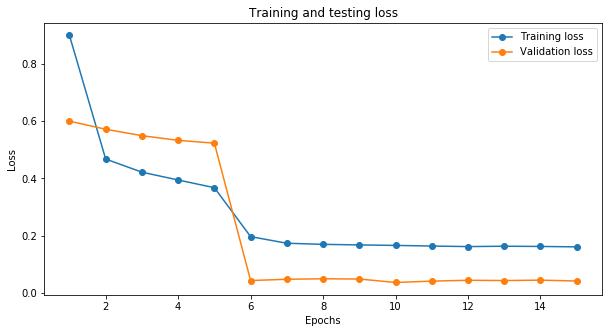

(5, 10)


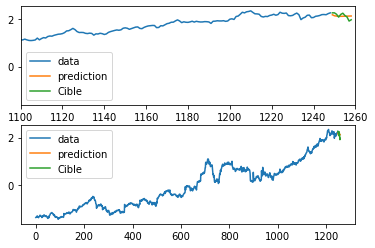

In [85]:
index = random.randint(0,399)
manager.train_strategieB( epochs=10, data_index=index, pts_2pred = 10)
manager.plot_metrics()
manager.plot_prediction(index, 1, pts_2pred = 10)

In [86]:
for param1, param2 in zip(manager.model.parameters(),manager.pre_trained_model.parameters()):
    print(param1.data == param2.data)


tensor([[[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [F

         [False]]])
tensor([[[False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         [False],
         [False],
         [False],
  

         [False, False]]])
tensor([[[False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         [False],
         [False],
         [Fal

         [False]]])


In [132]:
a= np.arange(10)
b= np.arange(10)
c= np.arange(10)
d = np.array([a,b,c])
d.shape

(3, 10)

In [129]:
a=[1,2,3,4,5,6,7,8,9,10]
b=np.array(a).reshape(1,10)
b.shape

(1, 10)